# Muse EEG

In this notebook we will train a model to determine whether a person's eyes are open or closed based on EEG signals from the Muse 2 headset.

## Running a Survey

First we can import our library and create a survey, so we can train a model on the resulting data. We'll ask the participant to first get into a comfortable position, then open eyes for 30s, close for 30s, etc. 3x.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Next step -- Just breathe normally, gently relax any tension, get in a comfortable position.
Next step -- Please open your eyes.


<IPython.core.display.Javascript object>


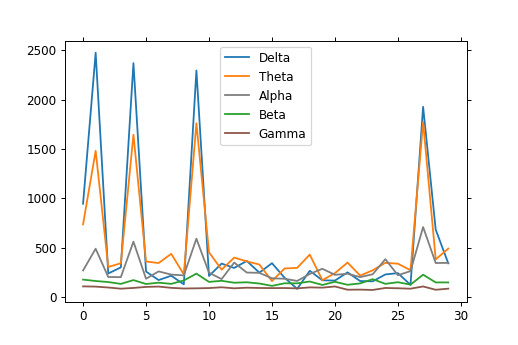

Successfully connected to muse device
Muse 2 Sample rate: 256
Muse 2 time correction: 1624829478.8588734
Next step -- Please close your eyes.


<IPython.core.display.Javascript object>


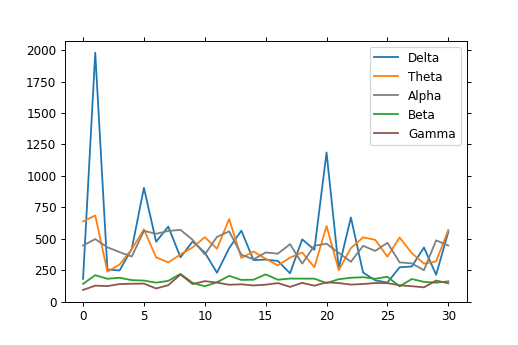

Next step -- Please open your eyes.


<IPython.core.display.Javascript object>


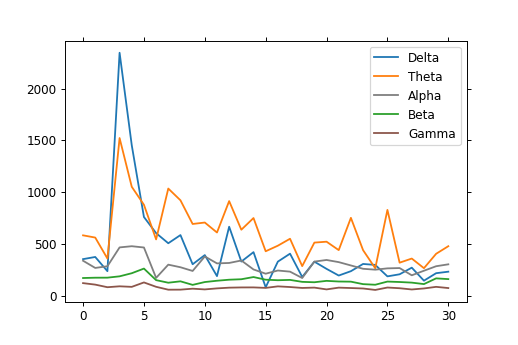

Next step -- Please close your eyes.


<IPython.core.display.Javascript object>


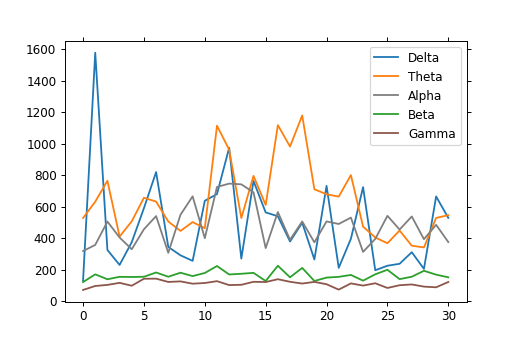

Next step -- Please open your eyes.


<IPython.core.display.Javascript object>


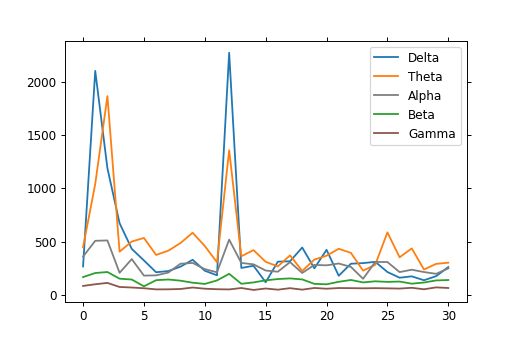

Next step -- Please close your eyes.


<IPython.core.display.Javascript object>


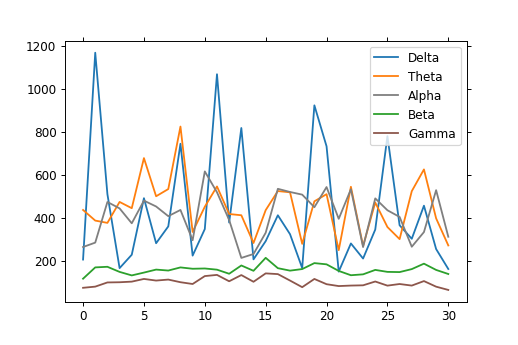

Next step -- Survey Completed. Thank you.


'../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-27 16:55:04.568128'

In [109]:
%matplotlib notebook
# Reload external source files when they change
%load_ext autoreload
%autoreload 2
import sys
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../src")
from recorder import Muse2EEGRecorder
from survey import Survey

eyes_open_step = (timedelta(seconds=30), "eyes_open", "Please open your eyes.", True)
eyes_closed_step = (timedelta(seconds=30), "eyes_closed", "Please close your eyes.", True)
eyes_schedule = [
    (timedelta(seconds=30), "intro", "Just breathe normally, gently relax any tension, get in a comfortable position.", False),
    eyes_open_step,
    eyes_closed_step,
    eyes_open_step,
    eyes_closed_step,
    eyes_open_step,
    eyes_closed_step
]

test_schedule = [
    (timedelta(seconds=5), "intro", "Just breathe normally, gently relax any tension, get in a comfortable position.", True)
]

muse2_recorder = Muse2EEGRecorder()
eyes_survey = Survey(muse2_recorder, "Eyes open-closed", "Eyes open for 30, closed for 30 - repeat 3x.", eyes_schedule)
eyes_survey.record("Jared")

## Preparing Data for Learning

We need to transform our raw survey data into a format suitable for supervised learning. We will create an input tensor with the shape required by PyTorch - `(batch_size, kernel_size, seq_len)`, aka `(Samples, Variables, Length / time or sequence steps)`, or `[batch_size, channels, num_features (aka: H * W)]`.

1. Batch size can be tuned. We will start with `64`.
2. The second index is the number of features per batch. In this case, we have four EEG sensors, so that will be `4`.
3. The number of samples included for each feature in each batch. This must be the same for every batch, so we will need to use a size <= the size of the smallest dataset we will use.

The PyTorch `DataLoader` is an alternative to batching out data manually. After creating a `Dataset`, the DataLoader will batch data with a given batch size.

In [125]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from eeg_preprocessing import preprocess_eeg_channel

class EEGSurveyDataset(Dataset):
    """
    Given a survey path, load each eeg_raw.csv file as a datum.
    """
    def __init__(self, survey_path, max_size, transform=None, target_transform=None):
        self.data_files = [survey_path + "/" + f for f in os.listdir(survey_path) if f.endswith("eeg_raw.csv")]
        self.label_map = {f:self._parse_filename(f)[1] for f in self.data_files}
        self.ilabel_map = self._create_ilabel_map()
        self.max_size = max_size
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data_file = self.data_files[idx]
        data = pd.read_csv(data_file)[["eeg1", "eeg2", "eeg3", "eeg4"]].to_numpy()[:self.max_size]
        label = self.ilabel_map[self.label_map[data_file]]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return torch.from_numpy(data.T), label
    
    def _create_ilabel_map(self):
        ilabel_map = {}
        for key in self.label_map.keys():
            if key not in ilabel_map:
                ilabel_map[self.label_map[key]] = len(ilabel_map.keys())-1
        return ilabel_map
    
    def _parse_filename(self, filename):
        filename = filename.split("/")[-1]
        name, extension = filename.split(".", 1)
        num_tag, typ = name.split("-", 1)
        num, tag = num_tag.split("_", 1)
        return num, tag
    
class ChunkedDataset(Dataset):
    """
    Given a dataset that returns ndarrays, split each element into chunks not more than size `chunk_size`.
    """
    def __init__(self, dataset, chunk_size, axis=-1):
        self.axis = axis
        self.dataset = [sample for sample in self._gen(dataset, chunk_size)]
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def _gen(self, dataset, chunk_size):
        for data, label in dataset:
            length = data.shape[self.axis]
            if length > chunk_size:
                chunks = np.split(data, chunk_size, axis=self.axis)
                for chunk in chunks:
                    yield chunk, label
            else:
                yield data, label
    
class MultiDataset(Dataset):
    """
    Given a collection of datasets, create a single dataset.
    """
    def __init__(self, datasets):
        self.datasets = datasets

    def __len__(self):
        l = 0
        for ds in self.datasets:
            l += len(ds)
        return l

    def __getitem__(self, idx):
        ds_i, ii = self._index_to_dataset_index(idx)
        return self.datasets[ds_i][ii]
    
    def _index_to_dataset_index(self, idx):
        """
        Given a raw index into this dataset, return (1) the dataset responsible for this sample,
        and (2) the index of the requested datum, within that dataset.
        
        Returns: (dataset_idx, sample_idx)
        """
        ds_start_i = 0
        for ds_i, ds in enumerate(self.datasets, 0):
            ds_end_i = ds_start_i + len(ds)
            if ds_start_i <= idx and idx < ds_end_i:
                return ds_i, idx - ds_start_i
            else:
                ds_start_i += len(ds)
        
        raise Exception("Can't find index in datasets: " + str(idx))

def transform_normalize(data):
    for ch in range(data.shape[1]):
        data[:, ch] = preprocess_eeg_channel(data[:, ch])
        stddev = data[:, ch].std()
        if stddev != 0:
            data[:, ch] = (data[:, ch] - data[:, ch].mean()) / stddev
    return data

batch_size = 219

# Create PyTorch Datasets
ds1 = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-27 15:35:13.033803", 7665, transform=transform_normalize)
ds2 = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-27 15:42:18.386982", 7665, transform=transform_normalize)
ds3 = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-27 16:30:50.691073", 7665, transform=transform_normalize)
ds4 = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-27 16:35:02.095245", 7665, transform=transform_normalize)
ds5 = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-27 16:50:59.722742", 7665, transform=transform_normalize)
ds6 = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-27 16:55:04.568128", 7665, transform=transform_normalize)
ds1, ds2, ds3, ds4, ds5, ds6 = ChunkedDataset(ds1, batch_size), ChunkedDataset(ds2, batch_size), ChunkedDataset(ds3, batch_size), ChunkedDataset(ds4, batch_size), ChunkedDataset(ds5, batch_size), ChunkedDataset(ds6, batch_size)
train_dataset = MultiDataset([ds1, ds2, ds3, ds4, ds6])
test_dataset = MultiDataset([ds5])
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Evaluate Data Quality

Some

## PyTorch Model

Now we can create the neural network we will be training on the collected data. We will model it after the [simple BCI model by Sentdex](https://github.com/Sentdex/BCI).

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n_channels = 4
n_outputs = 2

# Create model
net = nn.Sequential(
    # Pass input to a 1D convolutional layer with a kernel size of 3, apply to activation function.
    nn.Conv1d(n_channels, 32, 3),
    nn.ReLU(),

    # Pass previous layer output to a 1D convolutional layer with a kernel size of 2, apply to activation function,
    # and get the max value from each kernel.
    nn.Conv1d(32, 32, 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Pass previous layer output to a 1D convolutional layer with a kernel size of 2, apply to activation function,
    # and get the max value from each kernel. (same as previous layer)
    nn.Conv1d(32, 32, 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Flatten the convolutions. Input shape: (a, b, c), Output shape: (a, b*c)
    nn.Flatten(),
    
    #nn.Dropout(0.5),
    # ?
    # XXX: The first number needs to be updated each time the input shapes change. We could instead
    #      Create a class-based Module, and do a single pass through the conv portion of the network
    #      in order to determine the actual size.
    #      (This technique is shown in https://www.youtube.com/watch?v=1gQR24B3ISE&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=7).
    #      For now, we can update this value as needed by commenting out all layers after Flatten(), then running the code
    #      below and inspecting the output shape. The x[1] value should be the first arg in the following line.
    nn.Linear(224, 512),  # ~= nn.LazyLinear(512)

    # Flatten the linear layer into the required number of outputs
    nn.Linear(512, n_outputs),
    nn.Softmax()
)

for i, data in enumerate(train_dataloader, 0):
    features, labels = data
    print("Model input shape:", features.shape)
    out = net(features.float())
    print("Model output shape:", out.shape)
    print(out)
    break

Model input shape: torch.Size([219, 4, 35])
Model output shape: torch.Size([219, 2])
tensor([[0.4868, 0.5132],
        [0.4865, 0.5135],
        [0.4903, 0.5097],
        [0.4845, 0.5155],
        [0.4901, 0.5099],
        [0.4887, 0.5113],
        [0.4886, 0.5114],
        [0.4876, 0.5124],
        [0.4875, 0.5125],
        [0.4943, 0.5057],
        [0.4878, 0.5122],
        [0.4899, 0.5101],
        [0.4875, 0.5125],
        [0.4819, 0.5181],
        [0.4892, 0.5108],
        [0.4893, 0.5107],
        [0.4873, 0.5127],
        [0.4873, 0.5127],
        [0.4903, 0.5097],
        [0.4821, 0.5179],
        [0.4875, 0.5125],
        [0.4924, 0.5076],
        [0.4906, 0.5094],
        [0.4876, 0.5124],
        [0.4921, 0.5079],
        [0.4875, 0.5125],
        [0.4874, 0.5126],
        [0.4864, 0.5136],
        [0.4851, 0.5149],
        [0.4894, 0.5106],
        [0.4799, 0.5201],
        [0.4849, 0.5151],
        [0.4910, 0.5090],
        [0.4900, 0.5100],
        [0.4825, 0.5175],
     

/home/jared/.local/share/virtualenvs/neurothink--t8FFcF9/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Training the model

100%|██████████| 80/80 [00:39<00:00,  2.03it/s]

Passes per epoch: 30.0
Final Loss: 0.4320499897003174
Final Accuracy: 76%


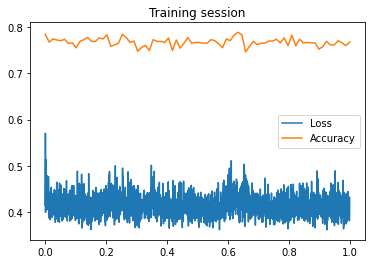

In [139]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train for n epochs
n = 80
test_while_training = True

loss_history = []
eval_history = []
count = 0
net.train()
for epoch in tqdm(range(n)):
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data

        # Zero gradients
        optimizer.zero_grad()
        #net.zero_grad()

        # Forward
        predictions = net(features.float())
        
        # Compute loss
        loss = criterion(predictions, labels.long())
        loss_history.append(loss.item())
        
        # Backward
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        count += 1
        
    # Evaluate the model against the test dataset
    if test_while_training:
        total = 0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                features, labels = data
                out = net(features.float())
                preds = F.log_softmax(out, dim=1).argmax(dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        eval_history.append(correct / total)

%matplotlib inline
plt.title("Training session")
print("Passes per epoch:", count / n)
print("Final Loss:", loss_history[-1])
plt.plot(np.linspace(0, 1, len(loss_history)), loss_history, label="Loss")
if test_while_training:
    print(f"Final Accuracy: {int(100*eval_history[-1])}%")
    plt.plot(np.linspace(0, 1, len(eval_history)), eval_history, label="Accuracy")
plt.legend()
plt.show()

In [141]:
net.eval()
total = 0
correct = 0
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        features, labels = data
        out = net(features.float())
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print("Correct:", correct, "/", total, "-", f"{int(correct / total * 100)}%")

Correct: 1008 / 1314 - 76%


## Save the Model

In [148]:
from datetime import datetime

torch.save(net.state_dict(), f"../models/{str(datetime.now())}-Muse_EEG_eyes_open-76percent.pt")